In [1]:
import pandas as pd
import numpy as np

In [2]:
from itertools import chain
from tqdm.notebook import tqdm

In [3]:
from catboost import CatBoostRanker, Pool, MetricVisualizer
from copy import deepcopy
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.model_selection import KFold, GroupKFold
from typing import Tuple

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm.auto import tqdm, trange
from sklearn.model_selection import GroupKFold, KFold
from itertools import chain
from tqdm.notebook import tqdm
from gensim.models import Word2Vec
import warnings
from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [5]:
def check_song_id_in_vocab(song_id, songs_embeddings):
    return song_id in songs_embeddings.wv

In [6]:
def get_user_embedding(sub_data, songs_embeddings):
    user_embeddings = {}
    positive_sessions = dict(sub_data[sub_data.target == 1].groupby("msno").song_id.apply(list))
    
    user_set = set(list(positive_sessions.keys()))
    for user, user_positives in positive_sessions.items():
        user_positives = [positive for positive in user_positives]
        if len(user_positives) > 0:
            user_embeddings[user] = songs_embeddings.wv[user_positives].mean(axis=0)
        
    return user_embeddings, user_set

In [7]:
def train_wv(sub_data):
    with tqdm(total=1.0, desc='Training...') as pbar:
        songs_ids, id_cnts = np.unique(sub_data.song_id, return_counts=True)
        songs_ids = set(songs_ids[id_cnts>5])
        pbar.update(0.1)    
        
        mask = [not(el in songs_ids) for el in sub_data.song_id]
        sub_data.loc[mask, 'song_id'] = np.array(['unknonw']*sum(mask))
        pbar.update(0.1)

        sessions = dict(sub_data.groupby("msno").song_id.apply(list))
        sentences = [values for values in sessions.values() if len(values) > 0]
        songs_embeddings = Word2Vec(sentences=sentences, vector_size=512, window=5, min_count=5, seed=0)
        pbar.update(0.3)
        
        user_embeddings, user_set = get_user_embedding(sub_data, songs_embeddings)
        pbar.update(0.5)
        
    return songs_embeddings, user_embeddings


In [8]:
def predict_wv(sub_data, songs_embeddings, user_embeddings):
    with tqdm(total=1.0, desc='Prediction...') as pbar:
        users_names = sub_data.msno.to_numpy()
        songs_ids = sub_data.song_id.to_numpy()
        pbar.update(0.01)
        
        unknown_songs_mask = np.array([not check_song_id_in_vocab(song, songs_embeddings) for song in songs_ids])
        songs_ids[unknown_songs_mask] = np.array(['unknonw']*sum(unknown_songs_mask))
        pbar.update(0.01)
        
        mask = np.array([(user in user_embeddings.keys()) for user in users_names])
        
        sub_embs_user = np.array([user_embeddings[el] for el in users_names[mask]])
        sub_embs_song = np.array([songs_embeddings.wv[el] for el in songs_ids[mask]])
        pbar.update(0.01)
        

        scores = np.zeros(len(sub_data))
        # за даталик извиняюсь
        scores[mask] = np.sum(sub_embs_user * sub_embs_song, axis=1)
        pbar.update(0.97)
        
    return scores

По сути это должна быть третья часть второго задания -- совмещение бустинга и неклассического эмбединга, но почсчитать это мой компуктер отказался

In [9]:
train = pd.read_csv('./data/train.csv')

In [10]:
# train = train.iloc[:1_000]

In [11]:
train = train.sample(frac=0.05, axis='rows', random_state=0)

In [12]:
train.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target
4536199,/fmKR9lJaIZOXKAgvWfSUc98J4xrLOz4cDTfbUH2vII=,MEmRb1tG6yYgWqj5mIeD6yvlBlHxXBGd+B2GVqOk11s=,my library,Local playlist more,local-library,1
2588100,RfvJIue264ZuupwbTzj4yfOQwlFxPNMS04rmmN6+RjM=,VqOqrfMxAOMwJpyfUSyWuPmHpMtSuzvrCvHgahApvDU=,discover,Discover Chart,online-playlist,0
1650329,KGePN4/k3/dRQsm8IiEYC+xKdeyQWRSywGXwPvfOgmA=,Zvw99EYxPKoSRMfcZBphA5aDQYzzfb1Ltskg+qbGI9c=,my library,Album more,album,1
2732406,q7ONdFffmNFYlkISz5MKpChB8MqpYcUI11zyGdiq1SE=,aCJOGcsHyppvmZsZdBVvC3zPeMft04O7THsJL6fmREs=,discover,Album more,album,0
613088,sI8A/1rBr36JHPw/jwHNj+s87Advzb5F4lP/WzJz394=,0mTPQwHn7HN3w+2h0KbcWHblsMLtVIxwz7Au+/qrmdU=,my library,Local playlist more,local-playlist,1


In [13]:
members = pd.read_csv('./data/members.csv')

In [14]:
members.head()

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,20110820,20170920
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,20150628,20170622
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,NaN,4,20160411,20170712
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,NaN,9,20150906,20150907
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,NaN,4,20170126,20170613


In [15]:
songs = pd.read_csv('./data/songs.csv')

In [16]:
songs.head()

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31.0
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0


In [17]:
data = train.merge(members).merge(songs)

In [18]:
data.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,city,bd,gender,registered_via,registration_init_time,expiration_date,song_length,genre_ids,artist_name,composer,lyricist,language
0,/fmKR9lJaIZOXKAgvWfSUc98J4xrLOz4cDTfbUH2vII=,MEmRb1tG6yYgWqj5mIeD6yvlBlHxXBGd+B2GVqOk11s=,my library,Local playlist more,local-library,1,15,27,male,9,20070427,20171021,233116,465,黃立行 (Stanley Huang),NaN,NaN,3.0
1,DZrCPrl7mH1J2X8aMCrq+DzeE3DT+mjNIsLKOZfwUg4=,MEmRb1tG6yYgWqj5mIeD6yvlBlHxXBGd+B2GVqOk11s=,radio,Local playlist more,local-library,1,14,26,female,9,20060303,20171019,233116,465,黃立行 (Stanley Huang),NaN,NaN,3.0
2,XFpHXorosYn0RcJ6ouV8D8LRowIxmlB9Bm6C7Y0QCV8=,MEmRb1tG6yYgWqj5mIeD6yvlBlHxXBGd+B2GVqOk11s=,explore,NaN,top-hits-for-artist,0,22,25,male,3,20150927,20170820,233116,465,黃立行 (Stanley Huang),NaN,NaN,3.0
3,prVac5s/C5LGKkK9KAhMrRL/8jbVzRla5H7UK3DV6DA=,MEmRb1tG6yYgWqj5mIeD6yvlBlHxXBGd+B2GVqOk11s=,discover,Artist more,top-hits-for-artist,1,22,26,male,7,20121105,20170930,233116,465,黃立行 (Stanley Huang),NaN,NaN,3.0
4,t3UHw5H0ejQ1Zg2MVNclxVL+7+m0iLzOnTTfs/3LpHY=,MEmRb1tG6yYgWqj5mIeD6yvlBlHxXBGd+B2GVqOk11s=,listen with,Others profile more,listen-with,0,15,32,male,9,20080617,20180413,233116,465,黃立行 (Stanley Huang),NaN,NaN,3.0


In [19]:
del songs, members

In [20]:
mask = ~data.gender.str.contains(r'male', na=False)

data.loc[mask, 'gender'] = pd.Series(['na']*mask.sum(), name='gender', index=mask[mask].index)

In [21]:
data.isna().sum(0)

msno                           0
song_id                        0
source_system_tab           1293
source_screen_name         20736
source_type                 1157
target                         0
city                           0
bd                             0
gender                         0
registered_via                 0
registration_init_time         0
expiration_date                0
song_length                    0
genre_ids                   5994
artist_name                    0
composer                   83756
lyricist                  158945
language                       0
dtype: int64

In [22]:
# точный возраст знать не обязательно -- разделим на условные "поколения"
mask=(data.bd < 10) | (data.bd >= 80)
young = (data.bd >= 10) & (data.bd < 20)
middle = (data.bd >= 20) & (data.bd < 40)
adult = (data.bd >= 40) & (data.bd < 60)
old = (data.bd >= 60) & (data.bd < 80)

data.loc[mask, 'bd'] = 'na'
data.loc[young, 'bd'] = 'young'
data.loc[middle, 'bd'] = 'middle'
data.loc[adult, 'bd'] = 'adult'
data.loc[old, 'bd'] = 'old'

In [23]:
data.loc[data.language==-1, 'language'] = 'na'
data.language = data.language.apply(lambda x: str(x))

In [24]:
data.fillna('na', inplace=True)

In [25]:
class GenresEnconding:
    def __init__(self, bins_number: int):
        self.labels = None
        self.id_to_indx = None
        self.indx_to_id = None
        self.bins_number = bins_number
        self.bins_size = None
    
    def fit(self, X: np.ndarray):
        self.labels = np.unique(list(chain(*[el.split('|') for el in X])))
        self.bins_size = len(self.labels) // self.bins_number + 1
        
        self.id_to_indx = {genre_id: i for i, genre_id in enumerate(self.labels)}
        self.indx_to_id = {i: genre_id for genre_id, i  in self.id_to_indx.items()}
        return self
        
    def transform(self, X: np.ndarray):
        result = np.zeros((len(X), self.bins_number))
        for i, genre_ids in enumerate(tqdm(X)):
            indxs = [self.id_to_indx.get(genre_id, self.id_to_indx['na']) for genre_id in genre_ids.split('|')]
            bin_enc = np.zeros(len(self.labels))
            bin_enc[indxs] = 1
            for b in range(self.bins_number):
                result[i, b] = np.power(2, bin_enc[b*self.bins_size:(b+1)*self.bins_size])[None,:] @ bin_enc[b*self.bins_size:(b+1)*self.bins_size]
        return result
        
    def fit_transform(self, X: np.ndarray):
        return self.fit(X).transform(X)
    

In [26]:
# Вахнот по жанрам добавляет слишком много фичей, так что сгруппируем ванхоты в группы битов и превратим их в десятичное число
ge = GenresEnconding(5)
genres_encodes = ge.fit_transform(data.genre_ids.values)

  0%|          | 0/368863 [00:00<?, ?it/s]

In [27]:
genres_encodes_df = pd.DataFrame(genres_encodes, columns=[f'genre_bin_{i}' for i in range(ge.bins_number)])

In [28]:
data = pd.concat([data.drop(columns=['genre_ids']), genres_encodes_df], axis=1)

In [29]:
del ge, genres_encodes

In [30]:
data.isna().sum(0)

msno                      0
song_id                   0
source_system_tab         0
source_screen_name        0
source_type               0
target                    0
city                      0
bd                        0
gender                    0
registered_via            0
registration_init_time    0
expiration_date           0
song_length               0
artist_name               0
composer                  0
lyricist                  0
language                  0
genre_bin_0               0
genre_bin_1               0
genre_bin_2               0
genre_bin_3               0
genre_bin_4               0
dtype: int64

In [31]:
data.columns

Index(['msno', 'song_id', 'source_system_tab', 'source_screen_name',
       'source_type', 'target', 'city', 'bd', 'gender', 'registered_via',
       'registration_init_time', 'expiration_date', 'song_length',
       'artist_name', 'composer', 'lyricist', 'language', 'genre_bin_0',
       'genre_bin_1', 'genre_bin_2', 'genre_bin_3', 'genre_bin_4'],
      dtype='object')

In [32]:
data.sort_values("msno", kind="stable", inplace=True)

In [33]:
data = data.groupby('msno').head(1023)

In [34]:
cat_feat_named = ['song_id', 'source_system_tab', 'source_screen_name',
       'source_type', 'city', 'bd', 'gender', 'registered_via',
       'artist_name', 'composer', 'lyricist', 'language']

noncat_features = ['song_length', 'genre_bin_0','genre_bin_1', 'genre_bin_2', 'genre_bin_3', 'genre_bin_4']

In [35]:
cat_features = [i for i in range(len(cat_feat_named))]

In [36]:
X = data[cat_feat_named+noncat_features].values
y = data['target'].values
queries = data['msno'].values

In [37]:
def get_split(train_indxs: np.ndarray, test_indxs: np.ndarray)-> Tuple[np.ndarray,np.ndarray,np.ndarray,np.ndarray,np.ndarray,np.ndarray]:
    X_train, X_test = X[train_indxs], X[test_indxs]
    y_train, y_test = y[train_indxs], y[test_indxs]
    queries_train, queries_test = queries[train_indxs], queries[test_indxs]
    
    return X_train, y_train, queries_train, X_test, y_test, queries_test

In [38]:
parameters = {
    'iterations': 2000,
    'custom_metric': ["QueryAUC:type=Ranking"],
    'verbose': False ,
    'random_seed': 0,
    'metric_period': 15, 
    'task_type': 'GPU',
    'loss_function': 'YetiRank',
    'train_dir': 'YetiRank/'
}

In [39]:
kfold = KFold(n_splits=5, shuffle=True, random_state=0)
train_index, test_index = next(kfold.split(data))
X_train, y_train, queries_train, X_test, y_test, queries_test = get_split(train_index, test_index)

# train_wv_emb, test_wv_emb = train_predict_wv(data.iloc[train_index], data.iloc[test_index])
songs_embeddings, user_embeddings = train_wv(data.iloc[train_index])

train_wv_emb = predict_wv(data.iloc[train_index], songs_embeddings, user_embeddings)
X_train = np.hstack([X_train, train_wv_emb[:, None]])
del train_wv_emb

test_wv_emb = predict_wv(data.iloc[test_index], songs_embeddings, user_embeddings)
X_test = np.hstack([X_test, test_wv_emb[:, None]])
del test_wv_emb

train = Pool(
    data=X_train,
    label=y_train,
    group_id=queries_train,
    cat_features=cat_features
)

test = Pool(
    data=X_test,
    label=y_test,
    group_id=queries_test,
    cat_features=cat_features
)

model = CatBoostRanker(**parameters)
model.fit(train, eval_set=test, plot=True)
score = model.get_evals_result()['validation']['QueryAUC:type=Ranking']
del X_train, y_train, queries_train, X_test, y_test, queries_test

Training...:   0%|          | 0/1.0 [00:00<?, ?it/s]

Prediction...:   0%|          | 0/1.0 [00:00<?, ?it/s]

Prediction...:   0%|          | 0/1.0 [00:00<?, ?it/s]

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric QueryAUC:type=Ranking is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


Text(0.5, 0, 'Iteration')

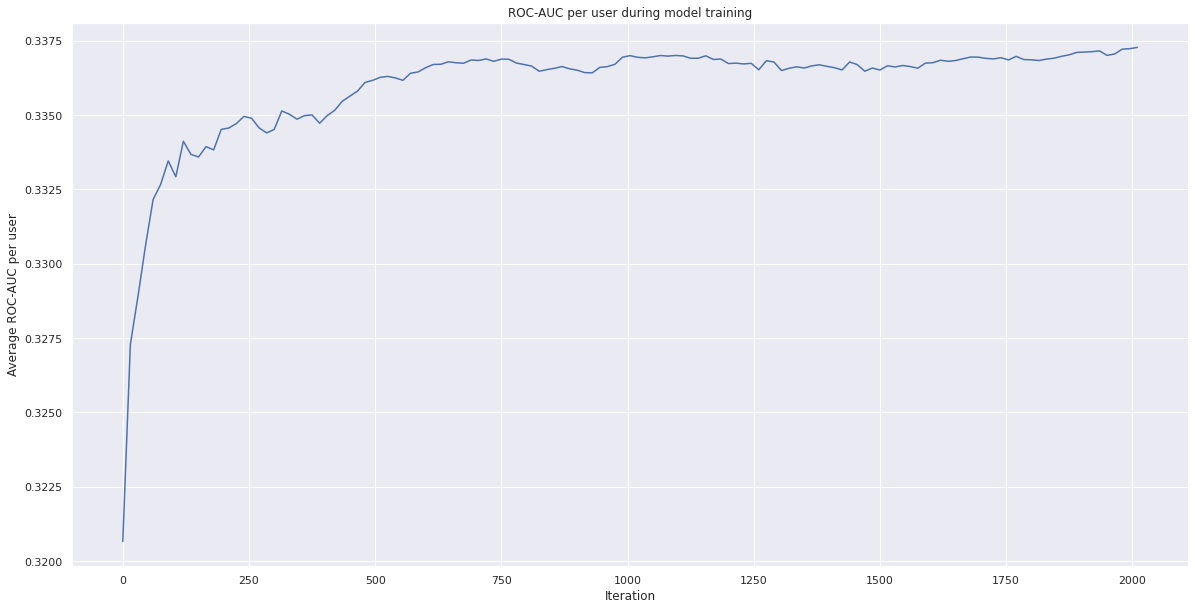

In [40]:
x = np.array((range(len(score))))*parameters['metric_period']
sns.set_theme(rc={"figure.figsize": (20, 10)})
ax = sns.lineplot(x=x, y=score)
ax.set_title("ROC-AUC per user during model training")
ax.set_ylabel("Average ROC-AUC per user")
ax.set_xlabel("Iteration")

2000 не дает значительного прироста в метриках, а считаются очень уж долго, поэтому сократим до 150

In [41]:
parameters = {
    'iterations': 150,
    'custom_metric': ["QueryAUC:type=Ranking"],
    'verbose': False ,
    'random_seed': 0,
    'metric_period': 15, 
    'task_type': 'GPU',
    'loss_function': 'YetiRank',
    'train_dir': 'YetiRank/'
}

In [42]:
group_kfold = GroupKFold(n_splits=5)
groups = data.msno.to_numpy()

scores = []
for train_index, test_index in group_kfold.split(data, groups=groups):
    X_train, y_train, queries_train, X_test, y_test, queries_test = get_split(train_index, test_index)
    
    train = Pool(
        data=X_train,
        label=y_train,
        group_id=queries_train,
        cat_features=cat_features
    )

    test = Pool(
        data=X_test,
        label=y_test,
        group_id=queries_test,
        cat_features=cat_features
    )
    
    model = CatBoostRanker(**parameters)
    model.fit(train, eval_set=test, plot=False)
    score = model.get_evals_result()['validation']['QueryAUC:type=Ranking']
    scores.append(score)
    del X_train, y_train, queries_train, X_test, y_test, queries_test

Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric QueryAUC:type=Ranking is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric QueryAUC:type=Ranking is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly

In [43]:
aucs = np.vstack([it for it in scores])
mean_auc = aucs.mean(axis=0)
std_auc = aucs.std(axis=0)

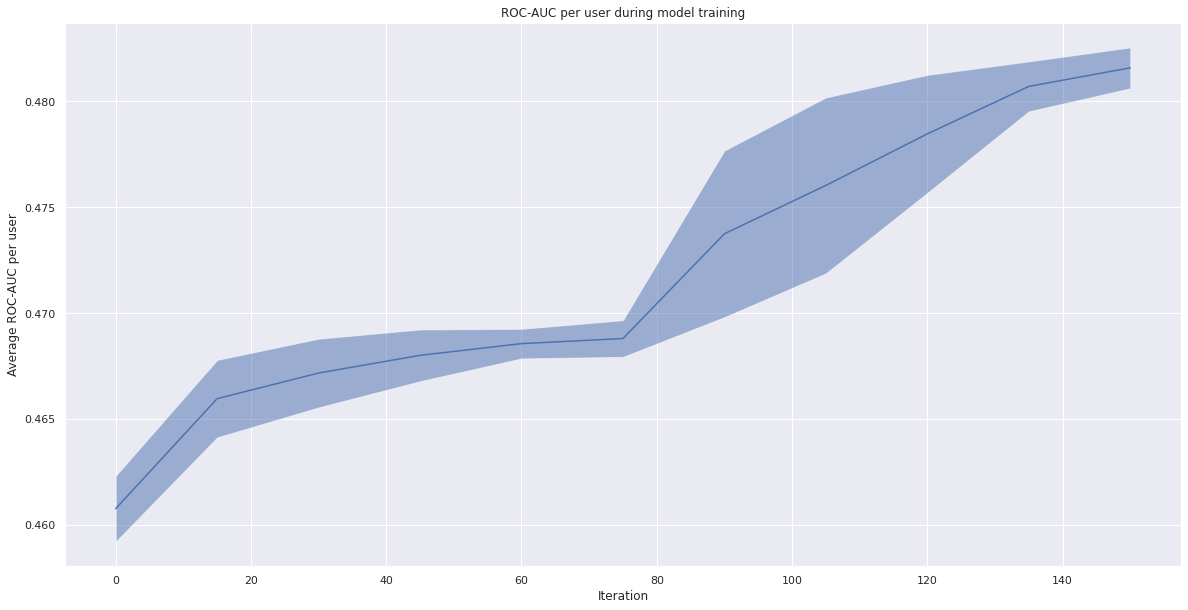

In [44]:
x = np.array(range(parameters['iterations']//parameters['metric_period']+1))*parameters['metric_period']
sns.set_theme(rc={"figure.figsize": (20, 10)})
ax = sns.lineplot(x=x, y=mean_auc)
ax.set_title("ROC-AUC per user during model training")
ax.set_ylabel("Average ROC-AUC per user")
ax.set_xlabel("Iteration")
ax.fill_between(x=x, y1 = mean_auc - std_auc, y2 = mean_auc + std_auc, alpha=.5)

In [45]:
mean_auc

array([0.4607626 , 0.46595883, 0.46716949, 0.46800536, 0.46855935,
       0.46879886, 0.47374589, 0.47603172, 0.47846562, 0.4807084 ,
       0.481585  ])